In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.patches as mpatches
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist
from matplotlib.gridspec import GridSpec

In [31]:
df = pd.read_csv("Data for Modeling/MPBROCKMETAL_KGsubset.csv")


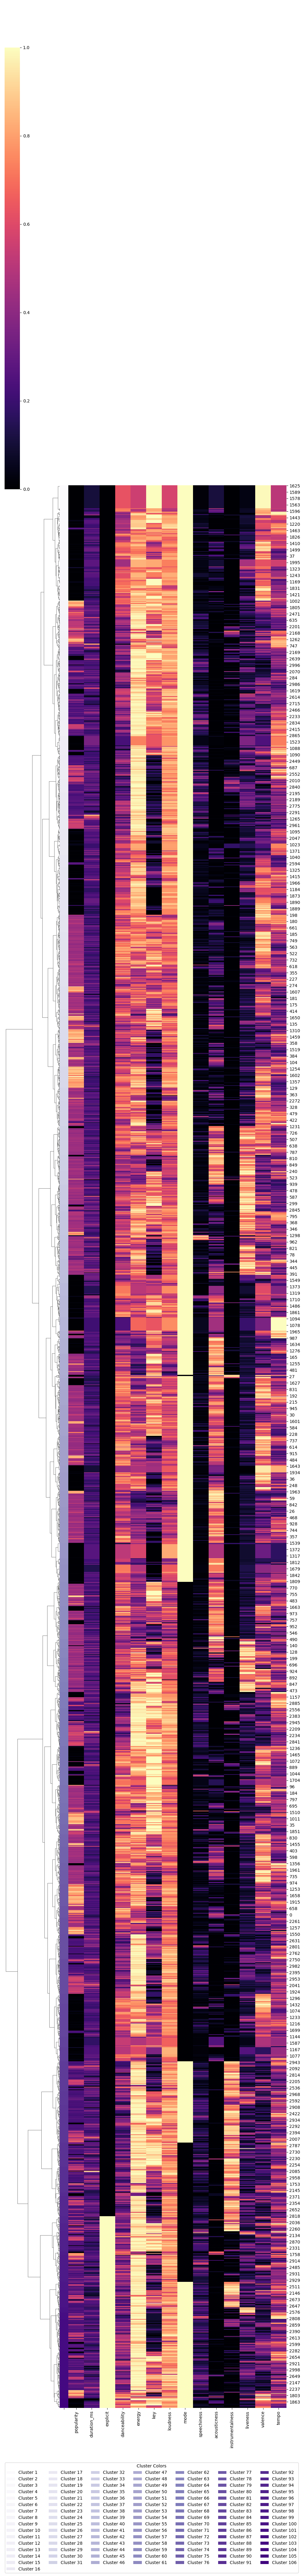

   popularity  duration_ms  explicit  danceability  energy  key  loudness  \
0          66       151565     False         0.765   0.497    1    -7.806   
1          65        89293     False         0.720   0.422    1   -13.338   
2          49       259066     False         0.632   0.651    7    -8.658   
3          49       216446     False         0.610   0.420    4   -10.889   
4          50       273906     False         0.580   0.330    7   -13.703   

   mode  speechiness  acousticness  instrumentalness  liveness  valence  \
0     0       0.0402         0.492          0.366000    0.1430    0.457   
1     0       0.0690         0.474          0.084700    0.1550    0.546   
2     0       0.0401         0.756          0.000004    0.7260    0.652   
3     0       0.0462         0.815          0.000000    0.1230    0.553   
4     1       0.0295         0.596          0.000001    0.0849    0.373   

     tempo  cluster  
0  112.195       79  
1  112.219       79  
2  119.567       65 

In [32]:


def hierarchical_clustering(df, iloc_lower, iloc_upper, num_clusters=106):
    # Load data
    X = df.iloc[:, iloc_lower:iloc_upper]

    # Step 2: Normalize using Min-Max scaling
    scaler = MinMaxScaler()
    normalized_data = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

    # Step 3: Perform hierarchical clustering
    Z = linkage(normalized_data, method='ward', metric='euclidean')

    # Step 4: Extract flat clusters (e.g., k=106 groups)
    num_clusters = 106
    clusters = fcluster(Z, num_clusters, criterion='maxclust')

    # Step 5: Create color palette for clusters
    palette = sns.color_palette("Purples", num_clusters)
    cluster_to_color = {cluster: palette[i] for i, cluster in enumerate(np.unique(clusters))}
    row_colors = pd.Series(clusters, index=normalized_data.index).map(cluster_to_color)

    # Step 6: Plot clustermap
    g = sns.clustermap(normalized_data,
                    row_linkage=Z,
                    col_cluster=False,
                    row_colors=row_colors,
                    cmap="magma",
                    figsize=(10, 80))

    # Step 7: Create custom legend (showing a subset for readability)
    # Show only first 10 clusters in legend to avoid clutter
    legend_clusters = list(cluster_to_color.keys())
    legend_elements = [Patch(facecolor=cluster_to_color[cl], label=f'Cluster {cl}') for cl in legend_clusters]

    # Place the legend below the heatmap
    plt.gcf().legend(handles=legend_elements,
                    title='Cluster Colors',
                    loc='lower center',
                    ncol=7,
                    bbox_to_anchor=(0.5, -0.05))

    plt.show()

    # Step 8: Attach cluster labels to the original data
    result = X.copy()
    result['cluster'] = clusters

    # Step 9: Output result
    print(result.head())
    # result.to_csv('clustered_output.csv') // create a function for all this code, Parameters: df , iloc lower bound, iloc upper bound
    return result


result = hierarchical_clustering(df,6,20 )
print(result)

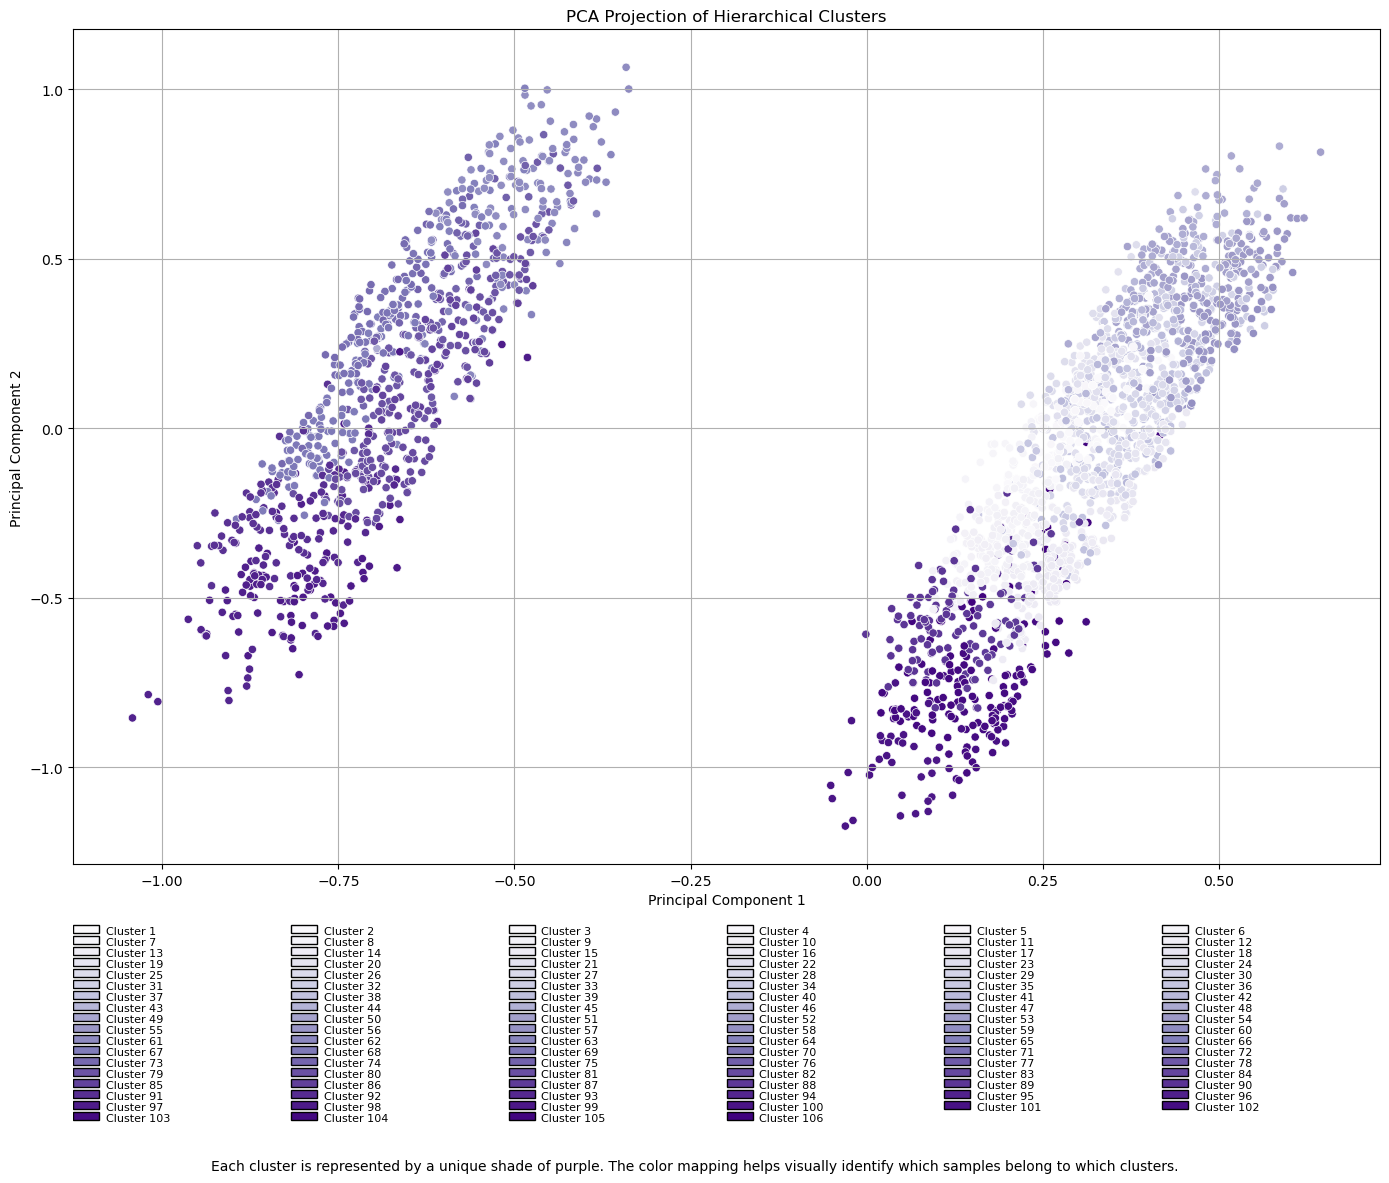

,PC1,PC2,cluster
0,-0.517205,0.462498,79
1,-0.451345,0.638049,79
2,-0.495144,0.722466,65
3,-0.428134,0.813609,60
4,0.434998,0.448380,50
...,...,...,...
2995,0.281309,-0.424130,16
2996,0.181394,-0.440955,10
2997,-0.753654,-0.515405,98
2998,0.148060,-0.714397,104


In [33]:
def plot_pca_clusters_with_legend(df, iloc_lower, iloc_upper, num_clusters=106):
    # --- Load and Normalize Data ---
    X = df.iloc[:, iloc_lower:iloc_upper]
    scaler = MinMaxScaler()
    normalized_data = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

    # --- Hierarchical Clustering ---
    Z = linkage(normalized_data, method='ward', metric='euclidean')
    clusters = fcluster(Z, num_clusters, criterion='maxclust')
    normalized_data['cluster'] = clusters

    # --- PCA ---
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(normalized_data.drop(columns='cluster'))
    pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'], index=X.index)
    pca_df['cluster'] = clusters

    # --- Color Palette ---
    palette = sns.color_palette("Purples", num_clusters)

    # --- Create Figure and Plot ---
    fig, (ax_main, ax_legend) = plt.subplots(2, 1, figsize=(14, 12), gridspec_kw={'height_ratios': [4, 1]})

    # --- PCA Scatterplot ---
    sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster', palette=palette, legend=False, ax=ax_main)
    ax_main.set_title("PCA Projection of Hierarchical Clusters")
    ax_main.set_xlabel("Principal Component 1")
    ax_main.set_ylabel("Principal Component 2")
    ax_main.grid(True)

    # --- Cluster Color Legend ---
    ax_legend.axis('off')
    n_cols = 6
    n_rows = -(-num_clusters // n_cols)  # Ceiling division

    x_spacing = 1.0 / n_cols
    y_spacing = 1.0 / (n_rows + 1)

    for i in range(num_clusters):
        col = i % n_cols
        row = i // n_cols
        x = col * x_spacing
        y = 1 - (row + 1) * y_spacing

        color_patch = mpatches.Rectangle((x, y), 0.02, 0.04, transform=ax_legend.transAxes,
                                         facecolor=palette[i], edgecolor='black')
        ax_legend.add_patch(color_patch)
        ax_legend.text(x + 0.025, y + 0.01, f'Cluster {i + 1}', transform=ax_legend.transAxes,
                       fontsize=8, va='center')

    # --- Caption ---
    plt.figtext(0.5, 0.02, "Each cluster is represented by a unique shade of purple. The color mapping helps visually identify which samples belong to which clusters.",
                ha='center', fontsize=10)

    plt.tight_layout(rect=[0, 0.04, 1, 1])
    plt.show()

    # Optional: return PCA and cluster info
    return pca_df
pca_df =plot_pca_clusters_with_legend(df,6,20)
pca_df


In [34]:
# Merge PCA results with clustering results
df_cluster_PCA = pd.merge(result, pca_df, left_index=True, right_index=True)

# Remove redundant cluster column
df_cluster_PCA.drop(columns=["cluster_y"], inplace=True)

# Reset index for easier access
df_cluster_PCA.reset_index(inplace=True)

# Extract PC1 and PC2 as lists
pc1 = df_cluster_PCA["PC1"].tolist()
pc2 = df_cluster_PCA["PC2"].tolist()

# Define distance function with sign adjustment based on PC1
def get_pca_distance_with_x_sign(x, y, boundary_x=-0.25, boundary_y=0):
    dist = np.sqrt((x - boundary_x)**2 + (y - boundary_y)**2)
    return -dist if x < boundary_x else dist

# Calculate signed Euclidean distance from the boundary
pc_distances = [get_pca_distance_with_x_sign(x, y) for x, y in zip(pc1, pc2)]

# Add distances to the dataframe
df_cluster_PCA["PCA_EuclidianDist(Xsign)"] = pc_distances

# Classify points based on the first boundary
def add_first_boundary_group(df, distance_column="PCA_EuclidianDist(Xsign)"):
    df["1th_Boundary"] = df[distance_column].apply(lambda x: -1 if x < 0 else 1)
    return df

df_cluster_PCA_gp = add_first_boundary_group(df_cluster_PCA)

# Merge original genre information for analysis
df_cluster_PCA_gp = pd.merge(df["track_genre"], df_cluster_PCA_gp, left_index=True, right_index=True)

# Separate groups for further analysis
groupA = df_cluster_PCA_gp[df_cluster_PCA_gp["1th_Boundary"] == -1]
groupB = df_cluster_PCA_gp[df_cluster_PCA_gp["1th_Boundary"] == 1]

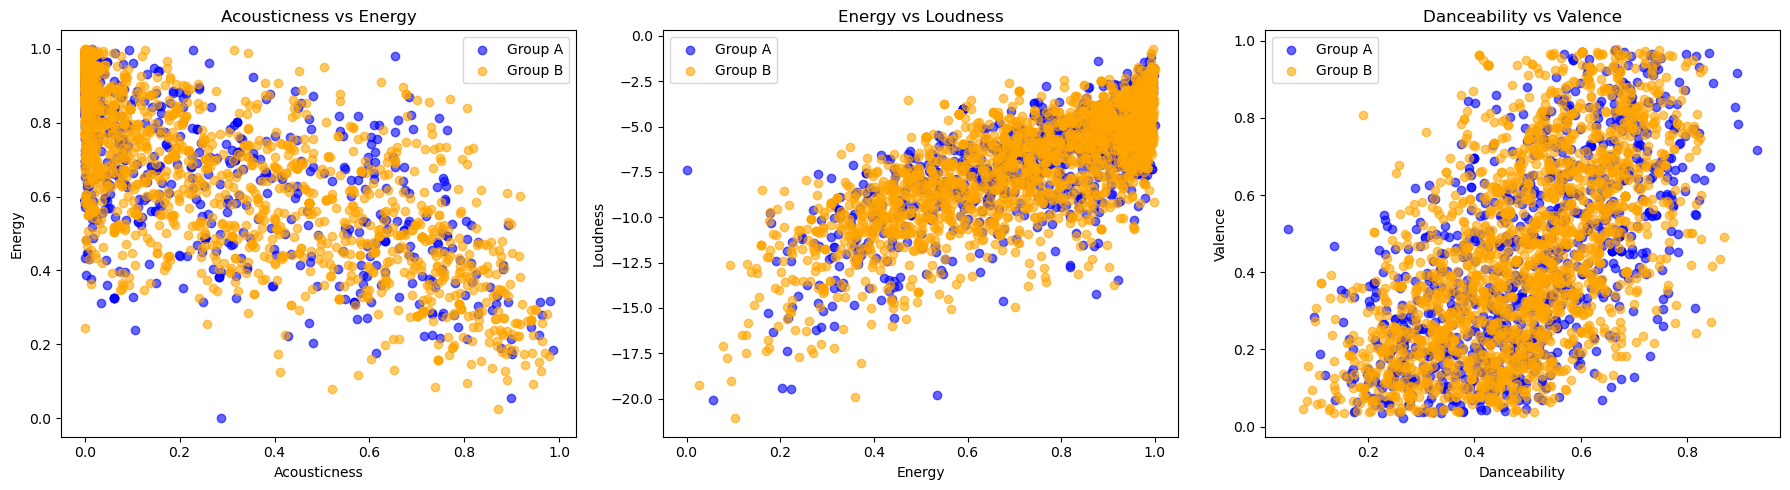

In [35]:
import matplotlib.pyplot as plt

def plot_feature_comparisons(groupA, groupB, comparisons, groupA_label='Group A', groupB_label='Group B'):
    """
    Plots 3 side-by-side scatter plots comparing features between two groups.
    
    Parameters:
    - groupA: DataFrame for Group A
    - groupB: DataFrame for Group B
    - comparisons: List of three (x_feature, y_feature) tuples
    - groupA_label: Label for Group A in the legend (default: 'Group A')
    - groupB_label: Label for Group B in the legend (default: 'Group B')
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    colors = ['blue', 'orange']
    
    for i, (x_feat, y_feat) in enumerate(comparisons):
        axes[i].scatter(groupA[x_feat], groupA[y_feat], color=colors[0], label=groupA_label, alpha=0.6)
        axes[i].scatter(groupB[x_feat], groupB[y_feat], color=colors[1], label=groupB_label, alpha=0.6)
        axes[i].set_xlabel(x_feat.capitalize())
        axes[i].set_ylabel(y_feat.capitalize())
        axes[i].set_title(f"{x_feat.capitalize()} vs {y_feat.capitalize()}")
        axes[i].legend()
    
    plt.tight_layout()
    plt.show()
comparisons = [("acousticness", "energy"), ( "energy", "loudness"), ("danceability","valence" )]
plot_feature_comparisons(groupA,groupB,comparisons)

In [36]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import pandas as pd

def pca_feature_contributions(df, iloc_lower, iloc_upper, n_components=2, sort_by='PC1'):
    """
    Runs PCA on a selected range of columns, normalizes the data, and returns feature contributions.

    Parameters:
        df (pd.DataFrame): The input dataframe.
        iloc_lower (int): The starting column index (inclusive).
        iloc_upper (int): The ending column index (exclusive).
        n_components (int): Number of PCA components to compute. Default is 2.
        sort_by (str): The principal component to sort the features by ('PC1', 'PC2', etc.).

    Returns:
        pd.DataFrame: Sorted PCA component loadings for each feature.
    """
    # Step 1: Select and normalize the data
    X = df.iloc[:, iloc_lower:iloc_upper]
    scaler = MinMaxScaler()
    normalized_data = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

    # Step 2: Fit PCA
    pca = PCA(n_components=n_components)
    pca.fit(normalized_data)

    # Step 3: Create DataFrame with component loadings
    component_labels = [f'PC{i+1}' for i in range(n_components)]
    pca_components = pd.DataFrame(
        data=pca.components_,
        columns=normalized_data.columns,
        index=component_labels
    )

    # Step 4: Return sorted contributions for the selected PC
    sorted_loadings = pca_components.T.sort_values(by=sort_by, ascending=False)
    print(f"Feature contributions sorted by {sort_by}:\n")
    print(sorted_loadings)

    return sorted_loadings

pca_f = pca_feature_contributions(df,6,20)
print(pca_f)

Feature contributions sorted by PC1:

                       PC1       PC2
mode              0.941287 -0.270838
acousticness      0.177116  0.503884
valence           0.092582  0.322209
danceability      0.046262  0.257952
liveness          0.018852 -0.006056
tempo             0.006292 -0.061811
duration_ms      -0.020770 -0.026353
popularity       -0.045738  0.048381
speechiness      -0.046865 -0.120539
loudness         -0.064208 -0.217542
explicit         -0.082406 -0.404737
instrumentalness -0.122890 -0.285855
energy           -0.134029 -0.417181
key              -0.151006  0.118654
                       PC1       PC2
mode              0.941287 -0.270838
acousticness      0.177116  0.503884
valence           0.092582  0.322209
danceability      0.046262  0.257952
liveness          0.018852 -0.006056
tempo             0.006292 -0.061811
duration_ms      -0.020770 -0.026353
popularity       -0.045738  0.048381
speechiness      -0.046865 -0.120539
loudness         -0.064208 -0.217542


In [37]:
del df["mode"]

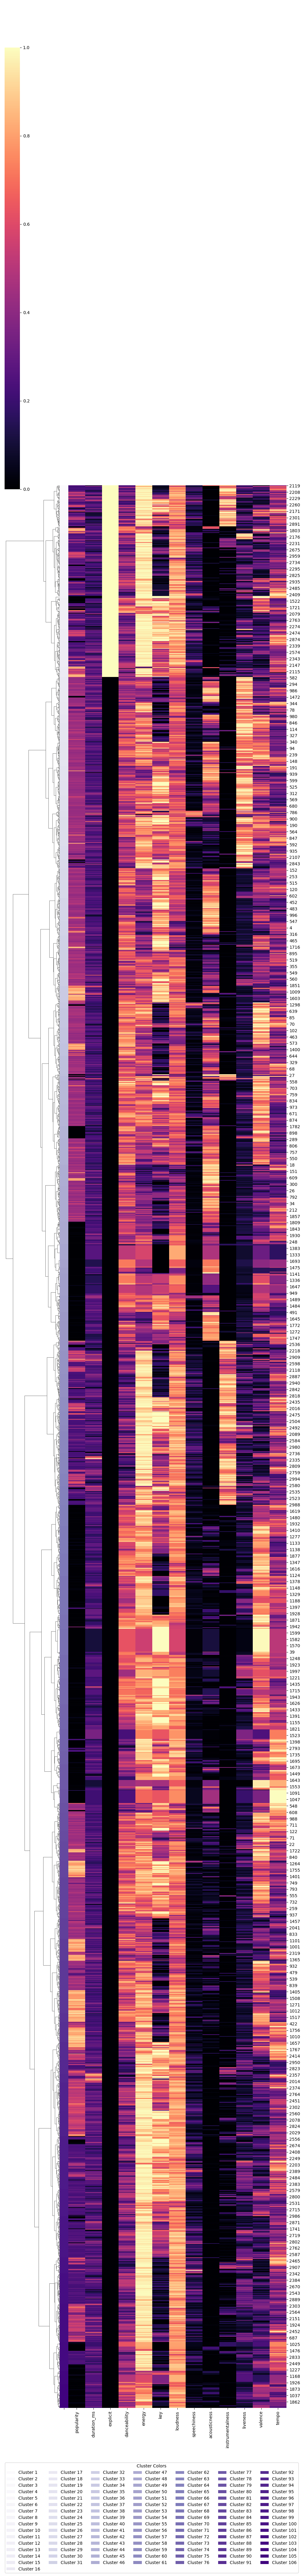

   popularity  duration_ms  explicit  danceability  energy  key  loudness  \
0          66       151565     False         0.765   0.497    1    -7.806   
1          65        89293     False         0.720   0.422    1   -13.338   
2          49       259066     False         0.632   0.651    7    -8.658   
3          49       216446     False         0.610   0.420    4   -10.889   
4          50       273906     False         0.580   0.330    7   -13.703   

   speechiness  acousticness  instrumentalness  liveness  valence    tempo  \
0       0.0402         0.492          0.366000    0.1430    0.457  112.195   
1       0.0690         0.474          0.084700    0.1550    0.546  112.219   
2       0.0401         0.756          0.000004    0.7260    0.652  119.567   
3       0.0462         0.815          0.000000    0.1230    0.553   96.313   
4       0.0295         0.596          0.000001    0.0849    0.373  136.408   

   cluster  
0       38  
1       38  
2       20  
3       45  
4  

In [38]:
result2 = hierarchical_clustering(df,6,19 )
print(result2)

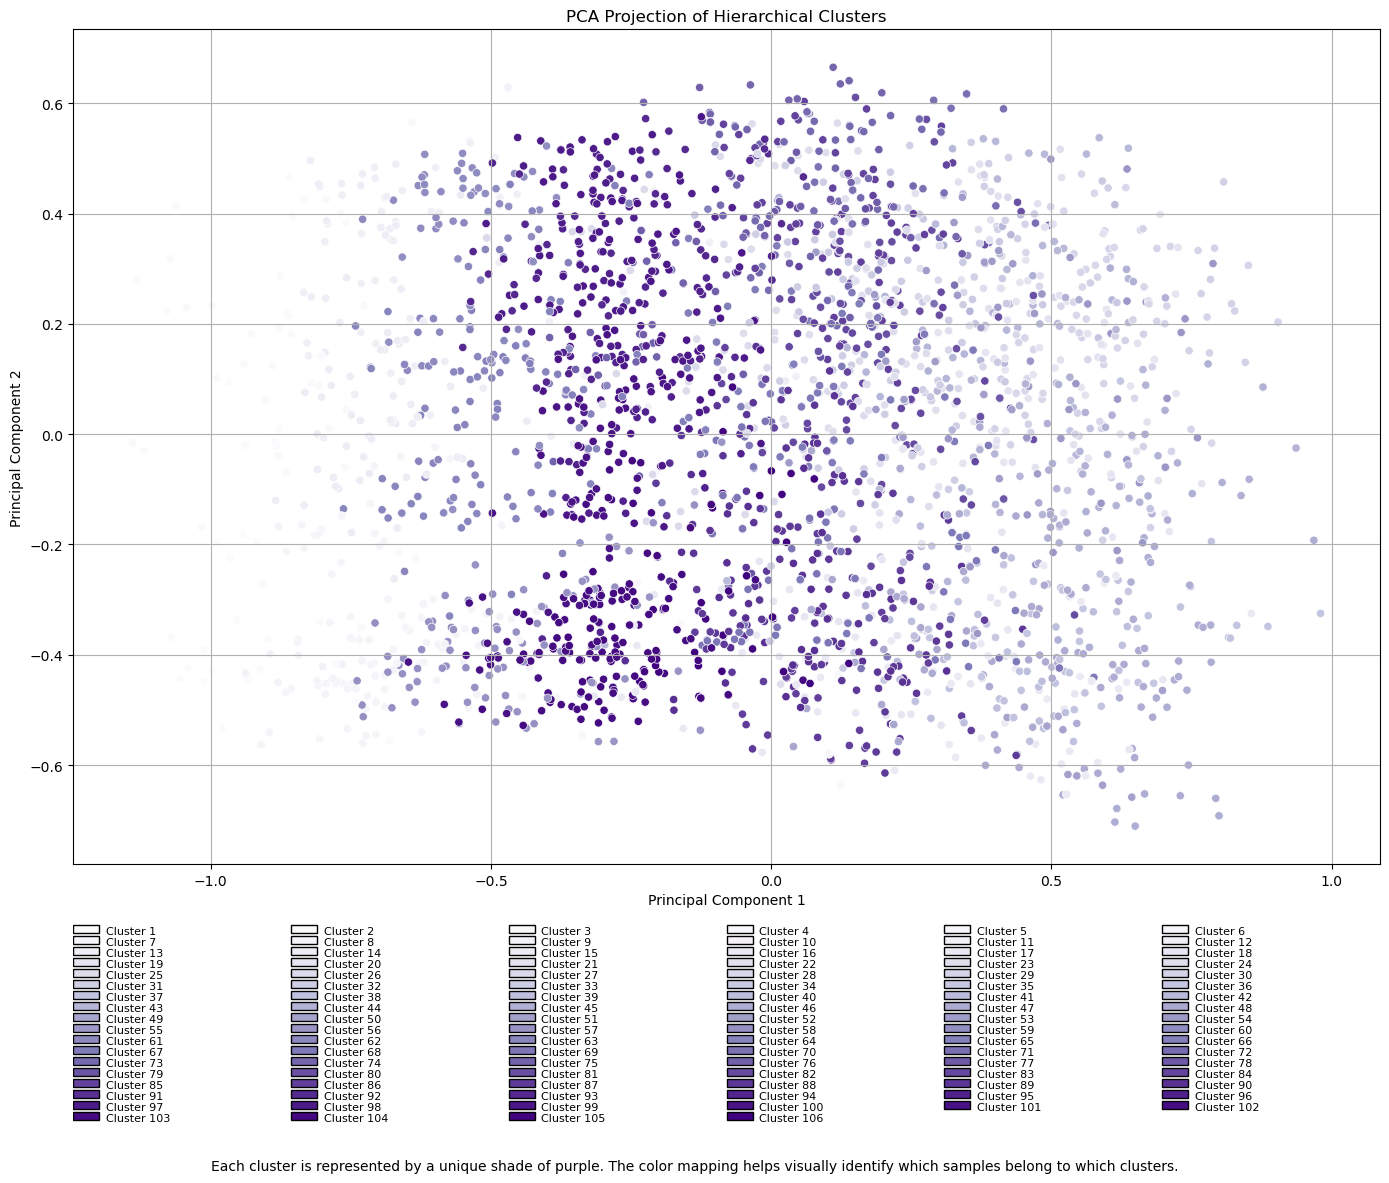

,PC1,PC2,cluster
0,0.317817,-0.460902,38
1,0.506695,-0.451429,38
2,0.553200,0.084895,20
3,0.672430,-0.223854,45
4,0.546521,0.038317,30
...,...,...,...
2995,-0.310477,-0.375755,102
2996,-0.379712,0.135940,100
2997,-0.683685,-0.299595,7
2998,-0.642556,0.053592,14


In [39]:
pca_df2 =plot_pca_clusters_with_legend(df,6,19)
pca_df2

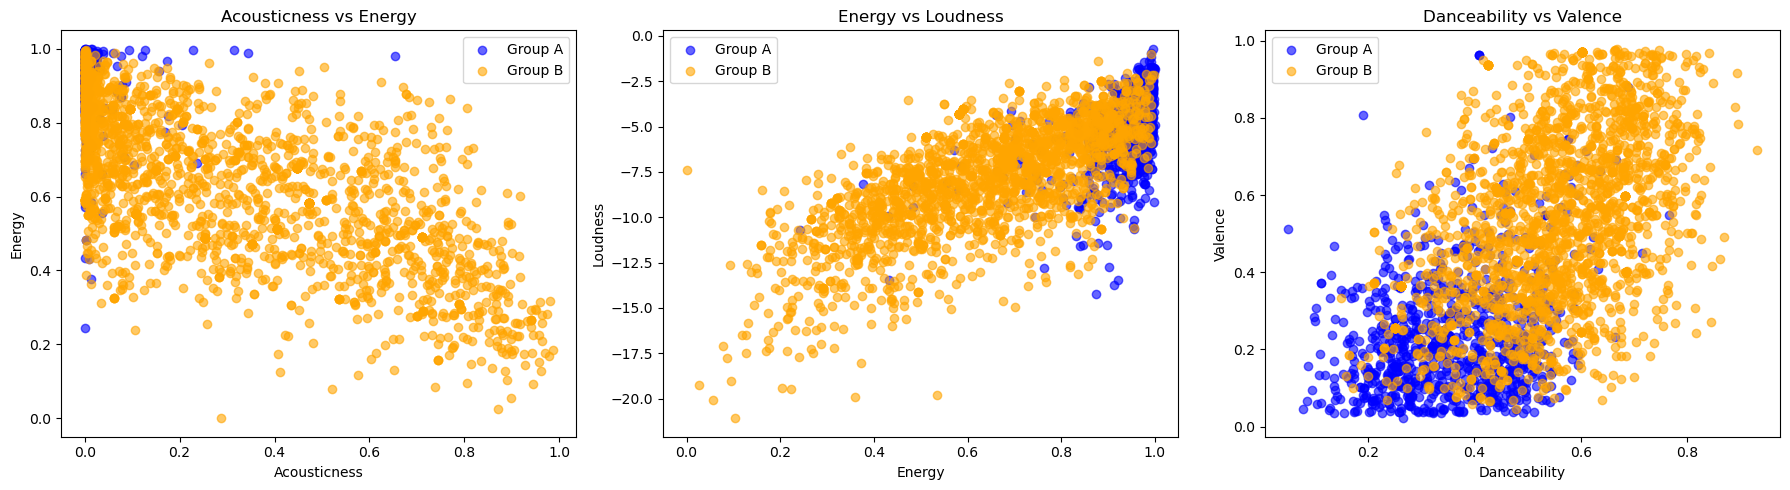

In [40]:
# Merge PCA results with clustering results
df_cluster_PCA2 = pd.merge(result2, pca_df2, left_index=True, right_index=True)

# Remove redundant cluster column
df_cluster_PCA2.drop(columns=["cluster_y"], inplace=True)

# Reset index for easier access
df_cluster_PCA2.reset_index(inplace=True)

# Extract PC1 and PC2 as lists
pc1_2 = df_cluster_PCA2["PC1"].tolist()
pc2_2 = df_cluster_PCA2["PC2"].tolist()

# Define distance function with sign adjustment based on PC1
def get_pca_distance_with_x_sign(x, y, boundary_x=-0.25, boundary_y=0):
    dist = np.sqrt((x - boundary_x)**2 + (y - boundary_y)**2)
    return -dist if x < boundary_x else dist

# Calculate signed Euclidean distance from the boundary
pc_distances_2 = [get_pca_distance_with_x_sign(x, y) for x, y in zip(pc1_2, pc2_2)]

# Add distances to the dataframe
df_cluster_PCA2["PCA_EuclidianDist(Xsign)"] = pc_distances_2

# Classify points based on the first boundary
def add_first_boundary_group(df, distance_column="PCA_EuclidianDist(Xsign)"):
    df["1th_Boundary"] = df[distance_column].apply(lambda x: -1 if x < 0 else 1)
    return df

df_cluster_PCA_gp2 = add_first_boundary_group(df_cluster_PCA2)

# Merge original genre information for analysis
df_cluster_PCA_gp2 = pd.merge(df["track_genre"], df_cluster_PCA_gp2, left_index=True, right_index=True)

# Separate groups for further analysis
groupA2 = df_cluster_PCA_gp2[df_cluster_PCA_gp2["1th_Boundary"] == -1]
groupB2 = df_cluster_PCA_gp2[df_cluster_PCA_gp2["1th_Boundary"] == 1]

plot_feature_comparisons(groupA2,groupB2,comparisons)

In [41]:
pca_f2 = pca_feature_contributions(df,6,19)

Feature contributions sorted by PC1:

                       PC1       PC2
acousticness      0.539950 -0.120650
valence           0.332354  0.165764
danceability      0.257340  0.033381
popularity        0.026454 -0.070637
key               0.023274  0.968018
liveness          0.002107 -0.016872
duration_ms      -0.032260 -0.018120
tempo            -0.055981  0.066508
speechiness      -0.130314  0.009343
loudness         -0.227597  0.035397
instrumentalness -0.314212 -0.021805
explicit         -0.405121 -0.048159
energy           -0.441266  0.075040
